# State vs Legacy Memory Optimization

Compare grid-search results for $(\gamma, w_0)$ between the state-based implementation (`src/Bayesian_state`) and the legacy Bayesian pipeline (`src/Bayesian`) on a shared subject.

In [13]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "Task2_processed.csv"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")

Project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data path: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed\Task2_processed.csv


In [14]:
import numpy as np
import pandas as pd

from copy import deepcopy
import matplotlib.pyplot as plt
from src.Bayesian_state.utils.load_config import MODEL_STRUCT
from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer
from src.Bayesian.utils.optimizer import Optimizer
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems.modules.memory import BaseMemory

In [15]:
subject_id = 17
beta_fixed = 5.0

gamma_resolution = 10
gamma_grid = np.linspace(0.1, 0.9, gamma_resolution)
w0_upper = 0.9
w0_grid = np.array([w0_upper / (idx + 1) for idx in range(gamma_resolution)], dtype=float)

legacy_module_config = {
    subject_id: {
        "memory": (
            BaseMemory,
            {
                "personal_memory_range": {
                    "gamma": (float(gamma_grid.min()), float(gamma_grid.max())),
                    "w0": (float(w0_grid.min()), float(w0_grid.max())),
                },
                "param_resolution": len(gamma_grid),
            },
        ),
    }
}

legacy_optimizer = Optimizer(legacy_module_config, n_jobs=1)
legacy_optimizer.prepare_data(DATA_PATH)

legacy_config = deepcopy(config_fgt)
legacy_config["param_bounds"]["beta"] = (beta_fixed, beta_fixed)
legacy_config["param_inits"]["beta"] = beta_fixed

legacy_results = legacy_optimizer.optimize_params_with_subs_parallel(
    legacy_config,
    subjects=[subject_id],
    window_size=16,
    grid_repeat=1,
    mc_samples=1,
    stop_at=0.5,
 )

legacy_best_params = legacy_results[subject_id]["best_params"]
legacy_best_gamma = float(legacy_best_params["gamma"])
legacy_best_w0 = float(legacy_best_params["w0"])
legacy_best_error = float(legacy_results[subject_id]["best_error"])

print(f"Legacy best gamma: {legacy_best_gamma:.4f}")
print(f"Legacy best w0: {legacy_best_w0:.4f}")
print(f"Legacy beta (fixed): {beta_fixed:.4f}")
print(f"Legacy mean error: {legacy_best_error:.6f}")

Using parallel optimization for multiple subjects.


Processing tasks: 100%|█████████████████████████████████████████| 100/100 [1:15:39<00:00, 45.40s/it]
INFO:src.Bayesian.utils.optimizer:Subject 17 has enough grid repeat samples.
Processing tasks: 100%|█████████████████████████████████████████| 100/100 [1:15:39<00:00, 45.40s/it]
INFO:src.Bayesian.utils.optimizer:Subject 17 has enough grid repeat samples.


Legacy best gamma: 0.1000
Legacy best w0: 0.0900
Legacy beta (fixed): 5.0000
Legacy mean error: 0.091616


In [16]:
state_engine_config = deepcopy(MODEL_STRUCT["m_model"])
state_engine_config["modules"]["likelihood_mod"]["kwargs"]["beta"] = beta_fixed

state_optimizer = StateModelGridOptimizer(
    state_engine_config,
    processed_data_dir=PROCESSED_DIR,
 )
state_optimizer.prepare_data(DATA_PATH)
state_results = state_optimizer.grid_search_subject(
    subject_id=subject_id,
    gamma_grid=gamma_grid,
    w0_grid=w0_grid,
    window_size=16,
    stop_at=0.5,
    max_trials=120,
 )
state_best = state_results["best"]

print(f"StateModel best gamma: {state_best.gamma:.4f}")
print(f"StateModel best w0: {state_best.w0:.4f}")
print(f"StateModel beta (fixed): {beta_fixed:.4f}")
print(f"StateModel mean error: {state_best.mean_error:.6f}")

Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.1}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.18888888888888888}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.18888888888888888}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.2777777777777778}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.2777777777777778}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.3666666666666667}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.3666666666666667}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.4555555555555556}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.4555555555555556}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.5444444444444445}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.5444444444444445}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.6333333333333333}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.6333333333333333}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.7222222222222222}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.7222222222222222}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.8111111111111111}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.8111111111111111}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.9, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.9, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.45, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.45, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.3, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.225, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.225, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.18, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.18, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.15, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.15, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1285714285714286, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1285714285714286, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1125, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1125, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.1, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.1, 'gamma': 0.9}
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.9}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.9}
StateModel best gamma: 0.1000
StateModel best w0: 0.0900
StateModel beta (fixed): 5.0000
StateModel mean error: 0.084170
StateModel best gamma: 0.1000
StateModel best w0: 0.0900
StateModel beta (fixed): 5.0000
StateModel mean error: 0.084170


Running State Model...
Initializing Partition: Calculating similarity matrix for 116 hypotheses using 100000 samples...


INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Similarity matrix calculation complete.
{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.09, 'gamma': 0.1}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.09, 'gamma': 0.1}
Legacy posteriors shape: (639, 116)
State posteriors shape: (639, 116)
Mean absolute difference: 0.000000
Max absolute difference: 0.000000
Legacy posteriors shape: (639, 116)
State posteriors shape: (639, 116)
Mean absolute difference: 0.000000
Max absolute difference: 0.000000


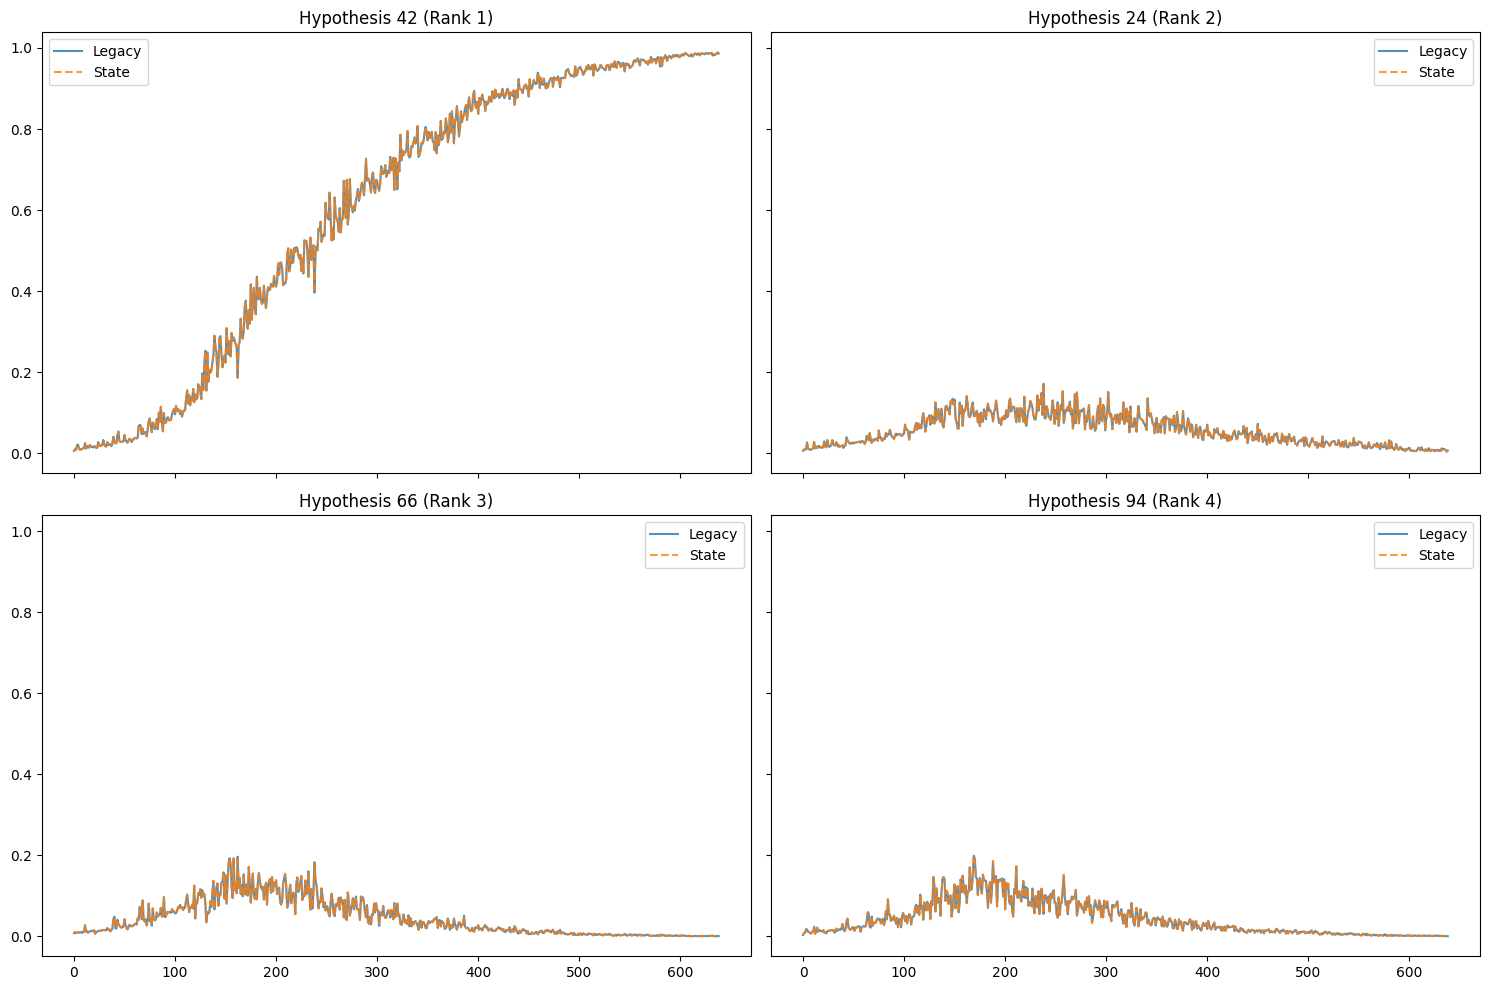

In [17]:
# Direct comparison of posterior sequences
from src.Bayesian.problems.model import StandardModel
from src.Bayesian_state.problems.model import StateModel
from src.Bayesian_state.utils.state_grid_optimizer import _prepare_trial_sequence

# 1. Prepare Data
subject_data = pd.read_csv(DATA_PATH)
sub_df = subject_data[subject_data["iSub"] == subject_id]
condition = sub_df["condition"].iloc[0]
stimulus = sub_df[["feature1", "feature2", "feature3", "feature4"]].values
choices = sub_df["choice"].values
responses = sub_df["feedback"].values
categories = sub_df["category"].values

# Legacy data format: tuple of arrays
legacy_data = (stimulus, choices, responses)
# State data format: list of [stim, choice, fb]
state_data = _prepare_trial_sequence(stimulus, choices, responses)

# 2. Run Legacy Model
legacy_run_config = deepcopy(config_fgt)
legacy_run_config["param_bounds"]["beta"] = (beta_fixed, beta_fixed)
legacy_run_config["param_inits"]["beta"] = beta_fixed

# Use the same module config structure as before
legacy_model = StandardModel(
    legacy_run_config, 
    module_config=legacy_module_config[subject_id], 
    condition=condition
)

# fit_step_by_step returns a list of dicts
# FIX: legacy_model.fit_step_by_step expects (stimulus, choices, responses)
legacy_step_results = legacy_model.fit_step_by_step(
    legacy_data,
    gamma=legacy_best_gamma,
    w0=legacy_best_w0
)

# Extract posteriors (n_trials x n_hypo)
n_trials = len(legacy_step_results)
n_hypo = len(legacy_model.hypotheses_set.elements)
legacy_posteriors = np.zeros((n_trials, n_hypo))

# Map hypothesis index to column index
hypo_to_idx = {h: i for i, h in enumerate(legacy_model.hypotheses_set.elements)}

for t, res in enumerate(legacy_step_results):
    for h_key, details in res['hypo_details'].items():
        legacy_posteriors[t, hypo_to_idx[h_key]] = details['post_max']

# 3. Run State Model
print("Running State Model...")
state_run_config = deepcopy(MODEL_STRUCT["m_model"])
state_run_config["modules"]["likelihood_mod"]["kwargs"]["beta"] = beta_fixed
# Inject best params
state_run_config["modules"]["memory_mod"]["kwargs"]["gamma"] = legacy_best_gamma
state_run_config["modules"]["memory_mod"]["kwargs"]["w0"] = legacy_best_w0

state_model = StateModel(
    state_run_config, 
    subject_id=subject_id,
    processed_data_dir=PROCESSED_DIR,
    condition=condition
)

# Check hypothesis sets
if legacy_model.hypotheses_set.elements != state_model.hypotheses_set.elements:
    print("Warning: Hypothesis sets differ!")
    print("Legacy:", legacy_model.hypotheses_set.elements[:10])
    print("State:", state_model.hypotheses_set.elements[:10])

# fit_step_by_step returns list of posteriors
state_posteriors_list = state_model.fit_step_by_step(state_data)
state_posteriors = np.array(state_posteriors_list)

# 4. Compare
print(f"Legacy posteriors shape: {legacy_posteriors.shape}")
print(f"State posteriors shape: {state_posteriors.shape}")

# Calculate difference
diff = np.abs(legacy_posteriors - state_posteriors)
mean_diff = np.mean(diff)
max_diff = np.max(diff)

print(f"Mean absolute difference: {mean_diff:.6f}")
print(f"Max absolute difference: {max_diff:.6f}")

# Identify top 4 hypotheses by total posterior mass
total_posterior = np.sum(legacy_posteriors, axis=0)
top_indices = np.argsort(total_posterior)[::-1][:4]

n_plot = min(4, len(top_indices))
rows = int(np.ceil(n_plot / 2))
cols = 2 if n_plot > 1 else 1

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
if n_plot > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i in range(n_plot):
    idx = top_indices[i]
    hypo_val = legacy_model.hypotheses_set.elements[idx]
    ax = axes[i]
    ax.plot(legacy_posteriors[:, idx], label="Legacy", alpha=0.8)
    ax.plot(state_posteriors[:, idx], label="State", alpha=0.8, linestyle="--")
    ax.set_title(f"Hypothesis {hypo_val} (Rank {i+1})")
    ax.legend()

plt.tight_layout()
plt.show()



In [18]:
comparison_df = pd.DataFrame([
    {
        "pipeline": "legacy",
        "gamma": legacy_best_gamma,
        "w0": legacy_best_w0,
        "beta": beta_fixed,
        "mean_error": legacy_best_error,
    },
    {
        "pipeline": "state",
        "gamma": state_best.gamma,
        "w0": state_best.w0,
        "beta": beta_fixed,
        "mean_error": state_best.mean_error,
    },
])
comparison_df

,pipeline,gamma,w0,beta,mean_error
0,legacy,0.1,0.09,5.0,0.091616
1,state,0.1,0.09,5.0,0.084170


In [19]:
state_grid_df = pd.DataFrame(
    [
        {"gamma": item.gamma, "w0": item.w0, "mean_error": item.mean_error}
        for item in state_results["grid"]
    ]
).sort_values("mean_error")
state_grid_df.head()

,gamma,w0,mean_error
9,0.100000,0.09,0.084170
19,0.188889,0.09,0.084437
29,0.277778,0.09,0.084738
39,0.366667,0.09,0.085081
8,0.100000,0.10,0.085111


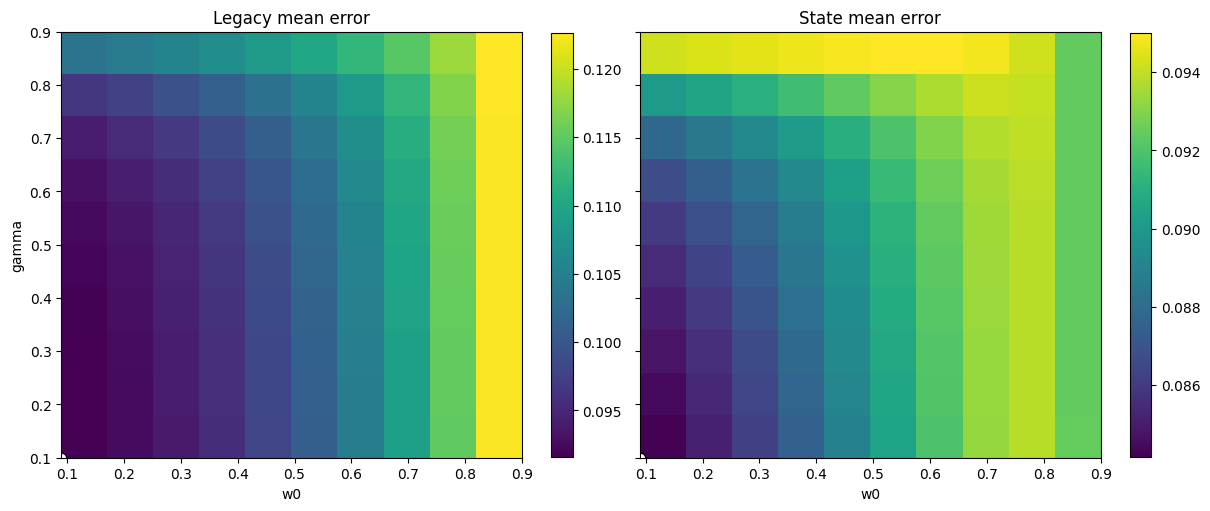

In [20]:
legacy_grid_df = pd.DataFrame(
    [
        {"gamma": float(gamma), "w0": float(w0), "mean_error": float(np.mean(errors))}
        for (gamma, w0), errors in legacy_results[subject_id]["grid_errors"].items()
    ]
)

legacy_pivot = legacy_grid_df.pivot_table(index="gamma", columns="w0", values="mean_error").sort_index().sort_index(axis=1)
state_pivot = state_grid_df.pivot_table(index="gamma", columns="w0", values="mean_error").sort_index().sort_index(axis=1)

vmin1 = legacy_grid_df["mean_error"].min()
vmin2 = state_grid_df["mean_error"].min()
vmax1 = legacy_grid_df["mean_error"].max()
vmax2 = state_grid_df["mean_error"].max()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True, sharey=True)

def plot_heatmap(ax, pivot, title, highlight_point, show_ylabel, vmin, vmax):
    w0_vals = pivot.columns.to_numpy(dtype=float)
    gamma_vals = pivot.index.to_numpy(dtype=float)
    im = ax.imshow(
        pivot.values,
        origin="lower",
        aspect="auto",
        extent=[w0_vals.min(), w0_vals.max(), gamma_vals.min(), gamma_vals.max()],
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_xlabel("w0")
    if show_ylabel:
        ax.set_ylabel("gamma")
    else:
        ax.set_ylabel("")
    ax.set_title(title)
    ax.scatter([highlight_point[1]], [highlight_point[0]], color="white", edgecolor="black", s=60)
    return im

im0 = plot_heatmap(axes[0], legacy_pivot, "Legacy mean error", (legacy_best_gamma, legacy_best_w0), True, vmin1, vmax1)
im1 = plot_heatmap(axes[1], state_pivot, "State mean error", (state_best.gamma, state_best.w0), False, vmin2, vmax2)

fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()